# Modelling Version 2

### Imports

In [34]:
# Standard library imports
from pathlib import Path
import os
import string
from itertools import combinations

# Third party imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr, pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    confusion_matrix,
    classification_report,
    make_scorer,
    fbeta_score
)
from xgboost import XGBClassifier

In [2]:
%matplotlib inline
sns.set_style('whitegrid')
sns.set(font_scale=1.2)

### Read in data

In [3]:
data_path = Path('../data')
processed_prem_path = os.path.join(data_path, 'processed', 'processed_prem_fixtures_v2.csv')
fixtures = pd.read_csv(processed_prem_path)

In [4]:
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7396 entries, 0 to 7395
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            7396 non-null   int64  
 1   date                                7396 non-null   object 
 2   season                              7396 non-null   int64  
 3   team_id                             7396 non-null   int64  
 4   team_name                           7396 non-null   object 
 5   opposition_id                       7396 non-null   int64  
 6   opposition_name                     7396 non-null   object 
 7   scored                              7396 non-null   float64
 8   conceded                            7396 non-null   float64
 9   relative_score                      7396 non-null   float64
 10  league_position                     7396 non-null   int64  
 11  opposition_league_position          7396 no

## Create features

First, let's remove any fixtures where there is no head to head data available (as the teams haven't played before in the data I have collected).

In [5]:
fixtures = fixtures[fixtures['average_hth_points'].notnull()]

As many of the feautures are still reliant on gathering information from the season the fixture is played in I will remove the first 4 fixtures so the model has access to more accurate information.

In [6]:
# Get rid of early season games
fixtures = fixtures[fixtures['games_played'] > 3]
fixtures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5778 entries, 40 to 7395
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   match_id                            5778 non-null   int64  
 1   date                                5778 non-null   object 
 2   season                              5778 non-null   int64  
 3   team_id                             5778 non-null   int64  
 4   team_name                           5778 non-null   object 
 5   opposition_id                       5778 non-null   int64  
 6   opposition_name                     5778 non-null   object 
 7   scored                              5778 non-null   float64
 8   conceded                            5778 non-null   float64
 9   relative_score                      5778 non-null   float64
 10  league_position                     5778 non-null   int64  
 11  opposition_league_position          5778 n

Again, I want to calculate relative statistics between some of the features to find the difference between the teams.

In [7]:
def get_relative_statistic(fixtures, feature):
    """
    Create relative statistics columns from features about each team in
    fixture. Params:
    - fixtures: pd.DataFrame
    - feature: Statistic to calculate relative statistics from.
    """
    # Get team and opposition stats
    columns = {'team': feature, 'opposition': '_'.join(['opposition', feature])}
    
    # Reset index to avoid concat issue
    new_fixtures = fixtures.reset_index(drop=True)
    
    # Calculate relative stat
    relative_stat = fixtures[columns['team']] - fixtures[columns['opposition']]
    relative_stat = relative_stat.rename('_'.join(['relative', feature]))

    return pd.concat([fixtures, relative_stat], axis=1)

In [8]:
statistics = [
    '_'.join([prefix, stat])
    for prefix in ('HA', 'season')
    for stat in ('average_scored', 'average_points', 'form', 'average_conceded')
]
statistics.append('league_position')
for stat in statistics:
    fixtures = get_relative_statistic(fixtures, stat)

I will create interaction terms to measure the interaction for different variables between the two teams. To do this I will create a function that will return the interaction terms between team and opposition and then calculate the relative stats of these.

It doesn't make sense to calculate interaction terms from variables that can both be negative, as any occurances when both variables are negative multiplied together will make a positive. This will lose the meaning of the negative values indicating a worse result, so I won't calculate the interaction variables between statistics that can both take negative values.

In [9]:
def get_interaction_terms(fixtures, features):
    """
    Returns interaction terms between team and opposition statistics and returns the
    relative of the interaction terms. Given the features inputed, creates interaction
    terms between team and opposition features. If both features contain negative
    results then these interaction terms are skipped.
    """
    # Label each feature alphabetically
    labeled_features = {string.ascii_uppercase[i]: feature for i, feature in enumerate(features)}
    
    interaction_terms = pd.DataFrame()
    
    # Loop through combinations of features
    for a, b in combinations(labeled_features.keys(), 2):
        
        # Some stats are the same for team and opposition, this determines the columns
        # needed for team and opposition
        feat_a = [labeled_features[a], '_'.join(['opposition', labeled_features[a]])]
        feat_a = feat_a if feat_a[1] in fixtures.columns else [feat_a[0]]*2
        
        feat_b = [labeled_features[b], '_'.join(['opposition', labeled_features[b]])]
        feat_b = feat_b if feat_b[1] in fixtures.columns else [feat_b[0]]*2
        
        # Don't calculate interaction varibales from two variables with negatives 
        if any(fixtures[feat_a[0]] < 0) and any(fixtures[feat_b[0]] < 0):
            continue
        
        # feat1 * opposition feat2
        stat1 = fixtures[feat_a[0]] * fixtures[feat_b[1]]
        
        # feat2 * opposition feat1
        stat2 = fixtures[feat_a[1]] * fixtures[feat_b[0]]
        
        # get relative of iteraction terms if stats calculated are different
        stat = stat1 if all(stat1 == stat2) else stat1 - stat2
        stat = stat.rename(f'{a}{b}')
        
        # Concat to all interaction terms
        interaction_terms = pd.concat([interaction_terms, stat], axis=1)
    
    # Reset index to avoid concat issues
    interaction_terms = interaction_terms.reset_index(drop=True)
    
    return pd.concat([fixtures.reset_index(drop=True), interaction_terms], axis=1)

In [10]:
interaction_features = [
    'league_position', 'HA_average_scored', 'HA_average_conceded', 'HA_average_points',
    'season_average_scored', 'season_average_conceded', 'season_average_points',
    'average_hth_points', 'average_hth_relative_score',
    'HA_form', 'season_form',
]
fixtures = get_interaction_terms(fixtures, interaction_features)

In [11]:
non_informative_cols = [
    'match_id',
    'date',
    'season',
    'team_id',
    'team_name',
    'opposition_id',
    'opposition_name',
    'scored',
    'conceded',
    'win'
]
fixture_features = ['average_hth_points', 'average_hth_relative_score']
team_features = [feat for feat in interaction_features if feat not in fixture_features]
team_features += ['_'.join(['opposition', feat]) for feat in team_features]

Now we can look at the correlation with relative score with our new interaction variables.

In [12]:
cols_to_drop = non_informative_cols + team_features + fixture_features
relative_score_corr = fixtures.drop(cols_to_drop, axis=1).corr()['relative_score'].abs()
relative_score_corr[relative_score_corr > 0.2].sort_values(ascending=False)[1:]

AB                                  0.414225
CE                                  0.409555
BF                                  0.407405
EF                                  0.404316
AD                                  0.403773
AE                                  0.403741
relative_season_average_scored      0.400154
relative_season_average_points      0.399421
AG                                  0.392420
BC                                  0.391758
relative_HA_average_points          0.386124
CG                                  0.385335
relative_HA_average_scored          0.385074
DF                                  0.382687
relative_league_position            0.380187
EH                                  0.375639
GH                                  0.375033
FG                                  0.374237
DH                                  0.365644
BH                                  0.363635
AH                                  0.361073
CD                                  0.355976
AF        

It looks like some of the interaction variables will be useful predictors, although it is likely some of the variables will be highly correlated. Before I do any modelling I will remove highly correlated variables.

## EDA

Now the target is the 'win' column, so first I will look at the variance of the target.

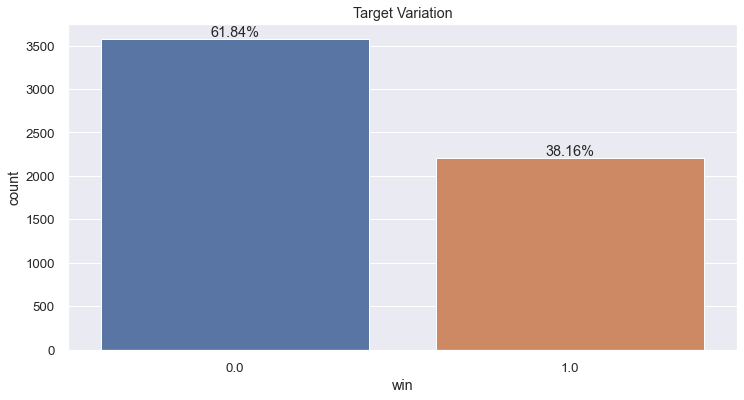

In [13]:
plt.figure(figsize=(12,6))
ax = sns.countplot(fixtures['win'])
no_fixtures = len(fixtures)
plt.title('Target Variation')

for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_height()
    ax.annotate(f'{100*y/no_fixtures:.2f}%', (x.mean(), y), ha='center', va='bottom')

As each fixture is repeated twice, the difference can be accounted for by the number of draws. 

Let's look at how the 'home' indicator effects the distribution of wins.

Text(61.0, 0.5, 'Home')

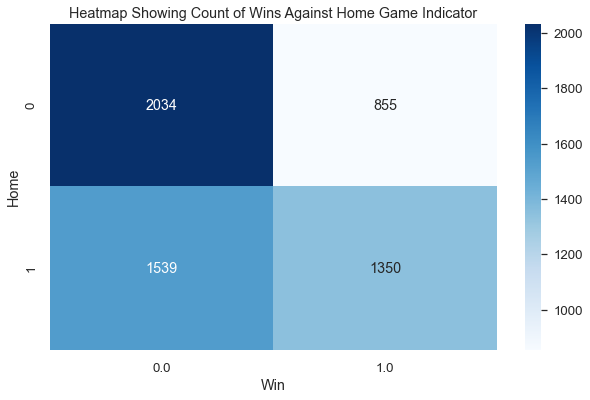

In [14]:
home_win_count = fixtures.pivot_table(index='home', columns='win', values='team_id', aggfunc='count')
plt.figure(figsize=(10, 6))
plt.title('Heatmap Showing Count of Wins Against Home Game Indicator')
sns.heatmap(home_win_count, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Win')
plt.ylabel('Home')

The heatmap shows that winning is more likley when playing at home and losing/drawing is more likley when playing away, therefore this will be a useful feature for prediction.

Now let's look if any of the features help to distinguish which team wins, again we will use the relative columns.

In [15]:
relative_cols = [
    'relative_HA_average_scored',
    'relative_season_average_scored',
    'relative_HA_average_conceded',
    'relative_season_average_conceded',
    'relative_HA_average_points',
    'relative_season_average_points',
    'relative_HA_form',
    'relative_season_form',
    'average_hth_points',
    'average_hth_relative_score',
    'relative_league_position',
]
target_col = 'win'

Now we can visualise any difference in distribution of the features based on the target.

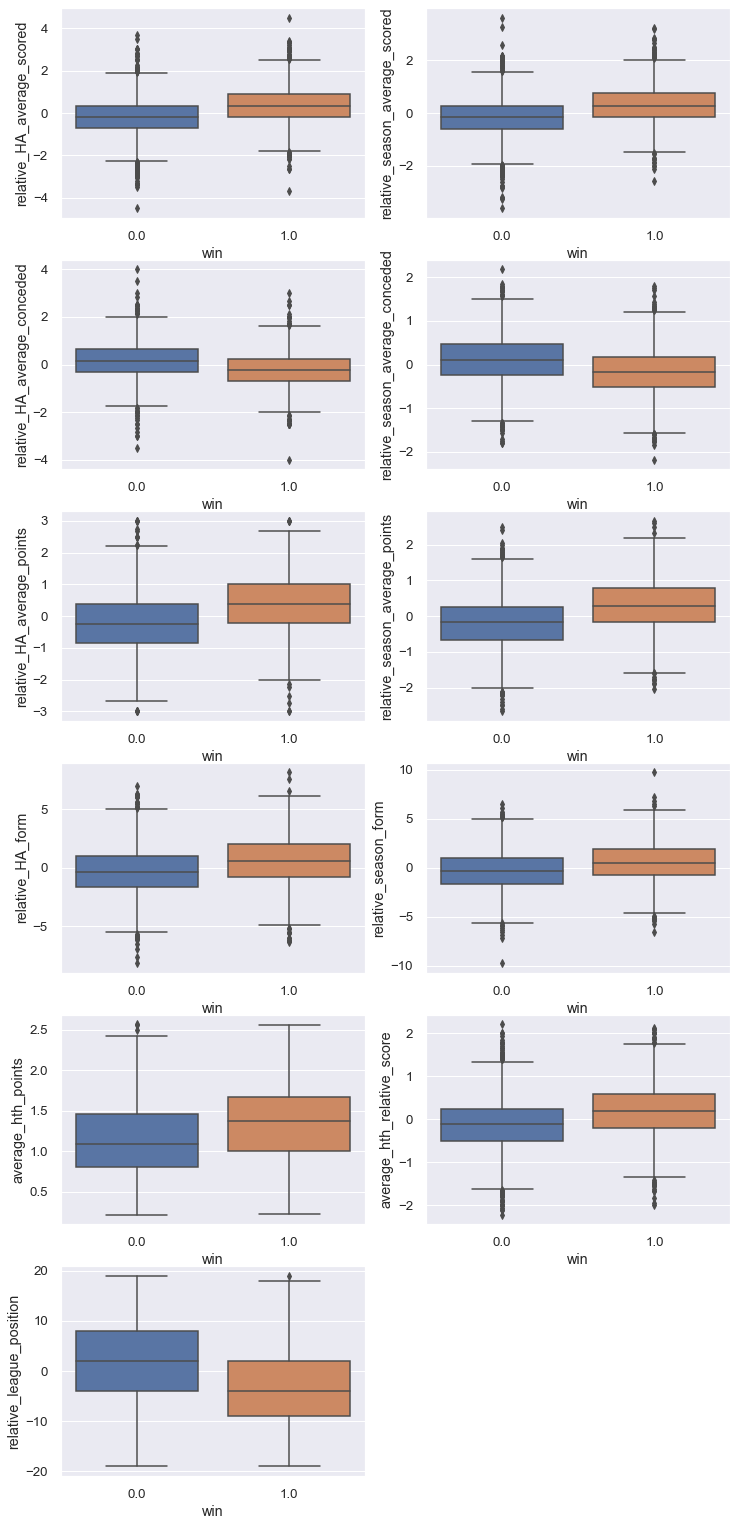

In [16]:
fig, axes = plt.subplots(
    int(np.ceil(len(relative_cols)/2)), 2, 
    figsize=(12, 5*len(relative_cols)//2))

# Remove last axes if odd features
if len(relative_cols)%2 != 0:
    fig.delaxes(axes[len(relative_cols)//2, 1])

# Plot axes
for ax, feature in enumerate(relative_cols):
    sns.boxplot(x=fixtures['win'], y=fixtures[feature], orient='v', ax=axes[ax//2, ax%2])

## Predict relative score

Let's once again try predicting the relative score, so that the degree of a win can be included in the model. First, I will seperate a subset of the features I want to use for modelling. The easiest way to do this will be to remove non informative columns and features that were soley useful for creating new features.

In [13]:
fixtures_2019 = fixtures[fixtures['season'] == 2019].reset_index(drop=True)
fixtures = fixtures[fixtures['season'] != 2019].reset_index(drop=True)

In [14]:
non_feature_cols = [
    'match_id', 'date', 'season', 'team_id', 'team_name', 'opposition_id',
    'opposition_name', 'scored', 'conceded', 'league_position', 
    'opposition_league_position',
    'HA_average_scored', 'opposition_HA_average_scored', 'HA_average_conceded',
    'opposition_HA_average_conceded', 'HA_average_points',
    'opposition_HA_average_points', 'HA_form', 'opposition_HA_form',
    'season_average_scored', 'opposition_season_average_scored',
    'season_average_conceded', 'opposition_season_average_conceded',
    'season_average_points', 'opposition_season_average_points',
    'season_form', 'opposition_season_form',
    'games_played', 'win'
]
features_subset = fixtures.drop(non_feature_cols, axis=1)

Now we can remove features that have a low correlation with relative score.

In [15]:
realtive_score_corr = features_subset.corr()['relative_score'].abs()
features = relative_score_corr[relative_score_corr > 0.1].index
features_subset = features_subset[features]

Now we want to remove features that have a high correlation. I will do this using a function that finds features that have a correlation over a threshold and then removes the feature with the lowest correlation.

In [16]:
def drop_correlated_features(dataframe, target, threshold):
    """
    Recursively finds the most highly correlated features (Pearson correlation)
    over the correlation threshold and then removes the feature with the least
    correlation (Pearson or Point Biserial if binary target) with the target variable.
    """
    # Compute feature correlations
    features = dataframe.drop(target, axis=1)
    bool_cols = [col for col in features 
             if np.isin(features[col].dropna().unique(), [0, 1]).all()]
    continuous_features = features.drop(bool_cols, axis=1)
    features_corr = continuous_features.corr().abs()
    
    # Take the upper triangle of feature correlations
    features_corr = features_corr.mask(np.tril(np.ones(features_corr.shape, dtype=np.bool_)))
    
    # Find index of correlations greater than the threshold
    correlated_features = zip(*np.where(features_corr > threshold))
    
    # Create dict, correlated features tuple : correlation
    correlated_features = {
        (features_corr.columns[i], features_corr.columns[j]): features_corr.iloc[i,j]
        for i,j in correlated_features
    }
    
    # If no correlations above threshold, return the dataframe
    if not correlated_features:
        return dataframe
    
    # Find most highly correlated features
    max_corr_features = max(correlated_features, key=correlated_features.get)
    
    # Set correlation metric
    correlation_metric = pearsonr
    if np.isin(dataframe[target].unique(), [0, 1]).all():
        correlation_metric = pointbiserialr
    
    # Find point correlation with target
    corrs_with_target = {
        feature: abs(correlation_metric(dataframe[target], dataframe[feature])[0])
        for feature in max_corr_features}

    # Drop feature with the least correlation with target
    feature_to_drop = min(corrs_with_target, key=corrs_with_target.get)
    new_dataframe = dataframe.drop(feature_to_drop, axis=1)
    
    return drop_correlated_features(new_dataframe, target, threshold)

I will set the threshold at 0.9 and see how the prediction performs.

In [17]:
features_subset = drop_correlated_features(features_subset, 'relative_score', 0.9)

I want to keep the 2019 set of fixtures out of the modelling to simulate my end model on betting data.

In [18]:
X = features_subset.drop('relative_score', axis=1)
y = features_subset['relative_score']
X_2019 = fixtures_2019[X.columns]
y_2019 = fixtures_2019['relative_score']

### Train Models

First, we split our data into a training and test set.

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Now I can scale the non binary features features.

In [20]:
def scale_features(X_train, X_test):
    """
    Fit scaler on X_train continuous features and transform continuous features
    in X_train and X_test.
    Input: X_train, X_test
    Output: X_train, X_test
    """
    bool_cols = [col for col in X_train
                 if np.isin(X_train[col].dropna().unique(), [0, 1]).all()]
    continuous_cols = [col for col in X_train.columns if col not in bool_cols]
    
    scaler = StandardScaler()
    scaler.fit(X_train[continuous_cols])
    
    scaled_X_train = pd.DataFrame(
        scaler.transform(X_train[continuous_cols]),
        columns=continuous_cols, index=X_train.index)
    scaled_X_train = pd.concat([scaled_X_train, X_train[bool_cols]], axis=1)
    
    scaled_X_test = pd.DataFrame(
        scaler.transform(X_test[continuous_cols]),
        columns=continuous_cols, index=X_test.index)
    scaled_X_test = pd.concat([scaled_X_test, X_test[bool_cols]], axis=1)
    
    return scaled_X_train, scaled_X_test

In [21]:
X_train, X_test = scale_features(X_train, X_test)

In [22]:
# Train linear regression
lin_reg = LinearRegression()
MSEs = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mean_MRSE = np.mean(np.sqrt(abs(MSEs)))
print('RMSE: ', mean_MRSE)

MRSE:  1.6711184012432319


In [23]:
# Train lasso
lasso = Lasso(max_iter=100000)
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
lasso_reg = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_reg.fit(X_train, y_train)
print(lasso_reg.best_params_)
print('Best CV MRSE: ', np.sqrt(abs(lasso_reg.best_score_)))
print('\n')

predictions = lasso_reg.best_estimator_.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
print('Test RMSE: ', np.sqrt(MSE))
print('Test MAE: ', MAE)

{'alpha': 0.01}
Best CV MRSE:  1.6703923167415475


Test MRSE:  1.6185578491372965
Test MAE:  1.2550757728889024


In [24]:
# Train ridge
ridge = Ridge(max_iter=100000)
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 40, 60, 80]}
ridge_reg = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_reg.fit(X_train, y_train)
print(ridge_reg.best_params_)
print('Best CV MRSE: ', np.sqrt(abs(ridge_reg.best_score_)))
print('\n')

predictions = ridge_reg.best_estimator_.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
print('Test RMSE: ', np.sqrt(MSE))
print('Test MAE: ', MAE)

{'alpha': 20}
Best CV MRSE:  1.6711645246145106


Test MRSE:  1.6167418434379195
Test MAE:  1.2555251772411302


In [29]:
# Linear SVR
linsvr = SVR(kernel='linear')
parameters = {
    'C': [1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
    'epsilon': [1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
linsvr_reg = GridSearchCV(linsvr, parameters, scoring='neg_mean_squared_error', cv=5)
linsvr_reg.fit(X_train, y_train)
print(linsvr_reg.best_params_)
print('Best CV MRSE: ', np.sqrt(abs(linsvr_reg.best_score_)))
print('\n')

predictions = linsvr_reg.best_estimator_.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
print('Test RMSE: ', np.sqrt(MSE))
print('Test MAE: ', MAE)

{'C': 1, 'epsilon': 1}
Best CV MRSE:  1.6714213161461664


Test MRSE:  1.6219677581740775
Test MAE:  1.2610591309209267


In [30]:
# RBF SVR
rbfsvr = SVR(kernel='rbf',)
parameters = {
    'C': [1e-4, 1e-3, 1e-2, 1, 5, 10, 20],
    'epsilon': [1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
rbfsvr_reg = GridSearchCV(rbfsvr, parameters, scoring='neg_mean_squared_error', cv=5)
rbfsvr_reg.fit(X_train, y_train)
print(rbfsvr_reg.best_params_)
print('Best CV MRSE: ', np.sqrt(abs(rbfsvr_reg.best_score_)))
print('\n')

predictions = rbfsvr_reg.best_estimator_.predict(X_test)
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
print('Test RMSE: ', np.sqrt(MSE))
print('Test MAE: ', MAE)

{'C': 1, 'epsilon': 1}
Best CV MRSE:  1.693097449502652


Test MRSE:  1.6368194080647671
Test MAE:  1.2690757148067013


There is marginal difference between the different regression algorithms but I will use ridge regression to predict the score of each match. Now we want to predict the relative score of all of our matches so we can use it as a feature when predicting if a team will win.

In [25]:
_, X = scale_features(X_train, X)
_, X_2019 = scale_features(X_train, X_2019)

predicted_scores = pd.Series(
    ridge_reg.best_estimator_.predict(X), name='predicted_relative_score')
predicted_scores_2019 = pd.Series(
    ridge_reg.best_estimator_.predict(X_2019), name='predicted_relative_score')

features = pd.concat([
    fixtures.drop(non_feature_cols, axis=1), predicted_scores, fixtures['win']], axis=1)
fixtures_2019 = pd.concat([fixtures_2019, predicted_scores_2019], axis=1)

features = features.drop('relative_score', axis=1)

## Win classifier

Again I want to drop highly correlated variables, this time the target is binary so the correlation metric used between continuous features and binary target will be Point Biserial correlation.

In [26]:
features = drop_correlated_features(features, 'win', 0.9)

Now I need to split my data into training and testing sets.

In [27]:
# Train test split
X = features.drop('win', axis=1)
y = features['win']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

Now I will scale the features.

In [28]:
X_train, X_test = scale_features(X_train, X_test)

I want to train my model so that it has as high as possible precision but also classifies as many wins as possible. I'm going to create a scorer that places importance on both precision and recall but more so on precision.

In [29]:
beta = 0.5
fbeta = make_scorer(fbeta_score, beta=beta, average='binary', pos_label=1)

Now I will define a function to print the evaluation metrics I will use to compare the models.

In [40]:
def print_model_eval(model, X_test, y_test, beta):
    """
    This function prints the weighted F1 score, confusion matrix and classification
    report.
    Input:
        - Model: Trained machine learning model.
        - X_test: Test features.
        - y_test: Test target.
        - beta: Beta argument for fbeta_score.
    """
    predictions = model.predict(X_test)
    print('Weighted F1 Score: ', fbeta_score(y_test, predictions, beta))
    print('\n')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    print('\n')
    print(classification_report(y_test, predictions))

### Train models

In [42]:
# Logistic regression
log = LogisticRegression(max_iter=10000)
parameters = {'C': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
log_grid = GridSearchCV(log, parameters, scoring=fbeta, cv=5)
log_grid.fit(X_train, y_train)

print('Best Params: ', log_grid.best_params_)
print_model_eval(log_grid.best_estimator_, X_test, y_test, beta)

Best Params:  {'C': 0.01}
Weighted F1 Score:  0.5756052992233895


Confusion Matrix:
[[844 143]
 [357 252]]


              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77       987
         1.0       0.64      0.41      0.50       609

    accuracy                           0.69      1596
   macro avg       0.67      0.63      0.64      1596
weighted avg       0.68      0.69      0.67      1596



In [174]:
# Linear SVC
linear_svc = SVC(kernel='linear')
parameters = {'C': [1e-3, 1e-2, 0.1, 1, 5, 10, 100]}
linsvc_grid = GridSearchCV(linear_svc, parameters, scoring=fbeta, cv=5)
linsvc_grid.fit(X_train, y_train)

print('Best Params: ', linsvc_grid.best_params_)
print_model_eval(linsvc_grid.best_estimator_, X_test, y_test, beta)

Best Params:  {'C': 1}
Weighted F1 Score:  0.5404671374253123


Confusion Matrix:
[[878 109]
 [410 199]]


              precision    recall  f1-score   support

         0.0       0.68      0.89      0.77       987
         1.0       0.65      0.33      0.43       609

    accuracy                           0.67      1596
   macro avg       0.66      0.61      0.60      1596
weighted avg       0.67      0.67      0.64      1596



In [175]:
# K neighbours
neighbours = KNeighborsClassifier()
parameters = {'n_neighbors': np.linspace(5,15,num=5,dtype='int')}
neighbours_grid = GridSearchCV(neighbours, parameters, scoring=fbeta, cv=5)
neighbours_grid.fit(X_train, y_train)

print('Best Params: ', neighbours_grid.best_params_)
print_model_eval(neighbours_grid.best_estimator_, X_test, y_test, beta)

Best Params:  {'n_neighbors': 15}
Weighted F1 Score:  0.5325443786982249


Confusion Matrix:
[[824 163]
 [375 234]]


              precision    recall  f1-score   support

         0.0       0.69      0.83      0.75       987
         1.0       0.59      0.38      0.47       609

    accuracy                           0.66      1596
   macro avg       0.64      0.61      0.61      1596
weighted avg       0.65      0.66      0.64      1596



In [30]:
# RBF SVC
rbf_svc = SVC(kernel='rbf')
parameters = {'gamma': [0.1, 1, 10, 100], 'C': [0.1, 1, 10, 100, 1000]}
rbfsvc_grid = GridSearchCV(rbf_svc, parameters, scoring=fbeta, cv=5)
rbfsvc_grid.fit(X_train, y_train)

print('Best Params: ', rbfsvc_grid.best_params_)
print_model_eval(rbfsvc_grid.best_estimator_, X_test, y_test, beta)

Best Params:  {'C': 1, 'gamma': 0.1}
Weighted F1 Score:  0.5325593134780414


Confusion Matrix:
[[855 132]
 [398 211]]


              precision    recall  f1-score   support

         0.0       0.68      0.87      0.76       987
         1.0       0.62      0.35      0.44       609

    accuracy                           0.67      1596
   macro avg       0.65      0.61      0.60      1596
weighted avg       0.66      0.67      0.64      1596



In [43]:
# Random Forest
forest = RandomForestClassifier()
parameters = {
    'min_samples_split': [2, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [5, 25, None],
    'max_features': [3, 10, 25, 'auto']
}
forest_grid = RandomizedSearchCV(forest, parameters, scoring=fbeta, cv=5, n_iter=40)
forest_grid.fit(X_train, y_train)

print('Best Params: ', forest_grid.best_params_)
print_model_eval(forest_grid.best_estimator_, X_test, y_test, beta)

Best Params:  {'n_estimators': 100, 'min_samples_split': 10, 'max_features': 10, 'max_depth': 5}
Weighted F1 Score:  0.5623529411764706


Confusion Matrix:
[[847 140]
 [370 239]]


              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77       987
         1.0       0.63      0.39      0.48       609

    accuracy                           0.68      1596
   macro avg       0.66      0.63      0.63      1596
weighted avg       0.67      0.68      0.66      1596



In [44]:
# Gradient Boosted Tree
xgboost = XGBClassifier()
parameters = {
    'eta': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}
xgboost_grid = RandomizedSearchCV(xgboost, parameters, scoring=fbeta, cv=5, n_iter=40, n_jobs=-1)
xgboost_grid.fit(X_train, y_train)

print('Best Params: ', xgboost_grid.best_params_)
print_model_eval(xgboost_grid.best_estimator_, X_test, y_test, beta)

Best Params:  {'min_child_weight': 3, 'max_depth': 3, 'gamma': 0.2, 'eta': 0.1, 'colsample_bytree': 0.3}
Weighted F1 Score:  0.5623582766439909


Confusion Matrix:
[[836 151]
 [361 248]]


              precision    recall  f1-score   support

         0.0       0.70      0.85      0.77       987
         1.0       0.62      0.41      0.49       609

    accuracy                           0.68      1596
   macro avg       0.66      0.63      0.63      1596
weighted avg       0.67      0.68      0.66      1596



The logistic regression model has the best fbeta score on the test set. I will use this as the best model for the betting simulation.

In [45]:
best_model = log_grid.best_estimator_

## Betting Simulation

In [46]:
odds_data_path = os.path.join(data_path, 'odds', 'prem_2019_odds.csv')
odds = pd.read_csv(odds_data_path, parse_dates=['Date'])
odds = odds[['Date', 'HomeTeam', 'AwayTeam', 'MaxH', 'MaxA']]

There are a few teams in the odds data set that have different names to the fixtures data set, so those need to be changed first.

In [47]:
team_name_map = {
    'Man United': "Manchester United",
    'Man City': "Manchester City",
    'Sheffield United': "Sheffield Utd",
}
odds['HomeTeam'] = odds['HomeTeam'].apply(lambda x: team_name_map.get(x, x))
odds['AwayTeam'] = odds['AwayTeam'].apply(lambda x: team_name_map.get(x, x))

Now I can add the betting odds for winning to the fixtures.

In [48]:
def get_odds(odds, team, opposition, home):
    """Returns the best betting odds for the team winning the match."""
    home_team = team if home else opposition
    away_team = opposition if home else team
    
    home_team = odds['HomeTeam'] == home_team
    away_team = odds['AwayTeam'] == away_team
    match = odds.loc[home_team & away_team]
    match = match.iloc[0]
    
    odds = match['MaxH'] if home else match['MaxA']
    return odds

In [49]:
fixtures_2019['odds'] = fixtures_2019.apply(
    lambda x: get_odds(odds, x['team_name'], x['opposition_name'], x['home']), axis=1)

Now I will use my model to predict if the team will win the match.

In [50]:
_, X_2019 = scale_features(X_train, fixtures_2019[X_train.columns])

In [51]:
predictions_2019 = pd.Series(best_model.predict(X_2019), name='win_prediction')
fixtures_2019 = pd.concat([fixtures_2019, predictions_2019], axis=1)

Now that I have the predictions and the odds I can choose which matches to bet on.

In [52]:
bet_made = fixtures_2019[(fixtures_2019['win_prediction'] == 1)]
bet_return = (bet_made['win'] * bet_made['odds']).sum()
print('Bets made: ', len(bet_made))
print('Return: ', bet_return)
print('Percent return: ', bet_return/len(bet_made))

Bets made:  167
Return:  160.28000000000003
Percent return:  0.9597604790419163


The model has not given a positive return.

In [55]:
print(f'Loss: {100 * (1 - bet_return/len(bet_made)):.2f}%')

Loss: 4.02%


Unfortunately, the model gives a loss of 4.02%. This, although disappointing, is not entirely surprising as the betting companies are very good at giving odds for games so that they make profit.

#### Improvements

To improve the model it would be to perform a more in depth analysis of the games played. Using information about individual players, injuries, possesion etc. would give a interesting analysis of how different teams perform.